**Digit recognizer**

**Data**: MNIST dataset

**Goal**: Build a deep learning model to predict, which number a hand written digit is. 

**By using Pytorch**

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms
import random
import torch.nn.functional as F
import math

In [2]:
class Net(nn.Module):
    #nn.module is the parent class for all pytorch models, it has some inbuilt functionalities which calculates gradients
    
    def __init__(self):# constructor
        
        super(Net,self).__init__()
        
        # 1 input layer of 784(28*28 flattened) and a hidden layer with 30 neuron and finally output layer of 10 neurons
        self.fc1=nn.Linear(784,30)
        self.drop=nn.Dropout(0.2)
        self.fc2=nn.Linear(30,10)
        
    def forward(self,x):
        #x-shape [64,784] [batchsize,inputsize]
        #layer-1
        l1=self.fc1(x)# l1-shape [64,30]
        
        #activation function-1
        al1=torch.sigmoid(l1)#al1-shape[64,30]
        
        #layer-2
        l2=self.fc2(al1)#l2-shape [64,10]
        
        #activation dunction-2
        al2=torch.sigmoid(l2)#al2-shape[64,10] which is our output
        
        return al2
    

In [3]:
def train(model,use_cuda,train_loader,optimizer,epoch):
    
    model.train()#tell the model to prepare for training
    
    for batchid,(data,target) in enumerate(train_loader): # get the batch
        
        #converting the data to [batch_size,784] from [batch_size,1,28,28]
        data = data.reshape([data.shape[0], 784]) # [batch_size,784]
        
        #converting the target to onehot encoding
        y_onehot = torch.zeros([target.shape[0], 10])  # Zero vector of shape [batch_size, 10]
        y_onehot[range(target.shape[0]), target] = 1 
        
        if use_cuda:
            data,y_onehot=data.cuda(),y_onehot.cuda() #setting the data to GPU if using Gpus
            
        optimizer.zero_grad()#setting the cumulative gradients to zero
        output=model(data)#forward pass through the model
        
        loss=torch.mean((output-y_onehot)**2)#calculating loss MSE
        loss.backward()#calculating gradients of the model
        optimizer.step()#updating model parameters . this step doesnt remove stored gradients
        
        if batchid % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batchid * len(data), len(train_loader.dataset),
            100. * batchid / len(train_loader), loss.item()))


In [4]:
def test(model,use_cuda,test_loader):
    
    model.eval()#to tell the model to be ready for evaluation
    
    test_loss=0
    correct=0
    
    with torch.no_grad():#to ensure gradients are not calculated as calculating gradients is not required for testing
        for data,target in test_loader:# getting the batch
            
            #converting the data to [batch_size,784] from [batch_size,1,28,28]
            data=data.reshape([data.shape[0],784])
            
            #converting the target to onehot encoding
            y_onehot=torch.zeros([target.shape[0],10])
            y_onehot[range(target.shape[0]),target]=1
            
            if use_cuda:
                data,y_onehot=data.cuda(),y_onehot.cuda()
                
            output=model(data)#forward pass
            
            test_loss+=torch.sum((output-y_onehot)**2)#sum up batch loss
            
            pred=output.argmax(dim=1,keepdim=True)#get index of maximum output
            correct += pred.eq(target.view_as(pred)).sum().item()#getting total number of correct samples
            
        test_loss/=len(test_loader.dataset)
        print(test_loss,100*correct/len(test_loader.dataset))#accuracy=total correct/total samples


In [5]:
def seed(seed_value):
    #this function removes randomness and makes everything deterministic
    #here we set the seed for torch.cuda,torch,numpy and random.
    #torch.cuda.manual_seed_all(seed_value) ,if we are using multi-GPU then we should use this to set the seed.
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

In [6]:
def main():
    use_cuda=False #if we have GPUs then we can set this true else False and program runs on the cpu
    seed(0) #used to fix the randomness of the code.
    
    #converting the dataset to tensor and normalizing the data by subtracting mean and dividing it by standard deviation,
    #normalizing results in the faster converging of model to optimal values.
    
    # x[0-255] => [0-1]
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,)) #((mean),(std))    (x-mean)/std
    ])
    
    data1=datasets.MNIST('../data',download=True,train=True,transform=transform)#getting the train dataset, shape=[60000,28,28]
    data2=datasets.MNIST('../data',train=False,transform=transform)#getting the test dataset. shape=[10000,28,28]
    
    #loading data using torch's inbuilt dataloader
    train_loader=torch.utils.data.DataLoader(data1,num_workers=2,batch_size=64,shuffle=True)#getting train dataloader
    test_loader=torch.utils.data.DataLoader(data2,num_workers=2,batch_size=1000,shuffle=False)#getting test dataloader
    
    model=Net()
    
    if use_cuda:
        model=model.cuda() # if we use GPUs we can put the model weights on GPU 
        
    optimizer=optim.SGD(model.parameters(),lr=10)#choosing the optimizer and setting the learning rate.
    
    for epoch in range(1,11):
        
        train(model,use_cuda,train_loader,optimizer,epoch)
        test(model,use_cuda,test_loader)

In [7]:
if __name__=="__main__":
    main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.285145
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.035109
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.022455
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.016793
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.017698
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.021430
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.014029
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.008732
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.013671
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.016153
tensor(0.1293) 92.58
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.008964
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.006504
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.009314
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.004609
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.013835
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.021412
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.010659
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.004104
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.009219
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

**Using Keras to build a NN model**

In [13]:
import tensorflow

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation

In [15]:
from keras.datasets import mnist

In [16]:
from keras.utils import np_utils

In [17]:
(xt,yt),(xte,yte)=mnist.load_data()

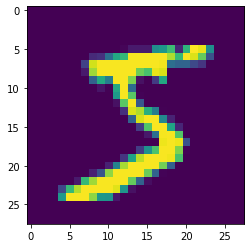

In [18]:
import matplotlib.pyplot as plt
plt.imshow(xt[0])
plt.show()

In [19]:
xt=xt.reshape(60000,784).astype('float32')
xte=xte.reshape(10000,784).astype('float32')
xt/=255
xte/=255

In [20]:
nb_classes = 10 # number of unique digits

Yt= np_utils.to_categorical(yt, nb_classes)
Yte = np_utils.to_categorical(yte, nb_classes)
yto=np.zeros([yt.shape[0],nb_classes])
yteo=np.zeros([yte.shape[0],nb_classes])
for i in range(yt.shape[0]):
    yto[i][yt[i]]=1
for i in range(yte.shape[0]):
    yteo[i][yte[i]]=1

In [21]:
type(yte)

numpy.ndarray

In [22]:
model=Sequential()                        #Linear stacking of layers

model.add(Dense(512,input_shape=(784,)))  #First layer with 512 nodes
model.add(Activation('relu'))             #Relu activation function 

model.add(Dense(50))                      #second layer with 50 nodes
model.add(Activation('relu'))             #relu activation layer
model.add(Dropout(0.2))                   #20% dropout of randomly selected nodes

model.add(Dense(10))                      #Final layer with 10 nodes and
model.add(Activation('softmax'))          #softmax activation function

2022-07-20 12:12:17.317551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-20 12:12:17.317592: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 12:12:17.317619: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2022-07-20 12:12:17.317945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 activation_2 (Activation)   (None, 10)                0

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.fit(x=xt,y=yto,batch_size=64,epochs=20)

Epoch 1/20
938/938 [==============================] - 2s 2ms/step - loss: 0.2733 - accuracy: 0.9198
Epoch 2/20
938/938 [==============================] - 2s 2ms/step - loss: 0.1080 - accuracy: 0.9677
Epoch 3/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0739 - accuracy: 0.9776
Epoch 4/20
938/938 [==============================] - 2s 3ms/step - loss: 0.0551 - accuracy: 0.9836
Epoch 5/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0434 - accuracy: 0.9867
Epoch 6/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0343 - accuracy: 0.9895
Epoch 7/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0314 - accuracy: 0.9893
Epoch 8/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0258 - accuracy: 0.9914
Epoch 9/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0210 - accuracy: 0.9930
Epoch 10/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0183 - accuracy: 0.9941

In [26]:
score = model.evaluate(xte,yteo)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 0s 977us/step - loss: 0.0969 - accuracy: 0.9828
Test score: 0.09686155617237091
Test accuracy: 0.9828000068664551


In [27]:
preds=model.predict(xte)
print(preds.shape)

313/313 [==============================] - 0s 857us/step
(10000, 10)


In [28]:
print(preds[1].argmax(),yteo[1].argmax())

2 2


In [29]:
preds=np.array([preds[i].argmax() for i in range(len(preds))])

In [30]:
from sklearn import metrics

In [31]:
print(metrics.precision_score(y_true=yte,y_pred=preds,labels=[1],average=None))

[0.99292035]


In [32]:
print(metrics.recall_score(y_true=yte,y_pred=preds,labels=[1],average=None))

[0.98854626]


In [33]:
model.summary()#categorical cross entropy loss function is used


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 activation_2 (Activation)   (None, 10)                0

**Adding convolution and maxpooling layers**

In [39]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization

In [40]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [41]:
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [42]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [43]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation_3 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 24, 24, 32)       

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [47]:
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [48]:
model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

Epoch 1/5


/tmp/ipykernel_5973/1017124850.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,


468/468 [==============================] - 29s 60ms/step - loss: 0.1263 - accuracy: 0.9607 - val_loss: 0.0545 - val_accuracy: 0.9840
Epoch 2/5
468/468 [==============================] - 28s 60ms/step - loss: 0.0490 - accuracy: 0.9853 - val_loss: 0.0394 - val_accuracy: 0.9864
Epoch 3/5
468/468 [==============================] - 28s 60ms/step - loss: 0.0392 - accuracy: 0.9888 - val_loss: 0.0381 - val_accuracy: 0.9870
Epoch 4/5
468/468 [==============================] - 28s 60ms/step - loss: 0.0337 - accuracy: 0.9893 - val_loss: 0.0269 - val_accuracy: 0.9920
Epoch 5/5
468/468 [==============================] - 28s 60ms/step - loss: 0.0310 - accuracy: 0.9903 - val_loss: 0.0376 - val_accuracy: 0.9881


In [49]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.0375 - accuracy: 0.9881
Test score: 0.03750322386622429
Test accuracy: 0.988099992275238
